# Example Proof-of-Concept 

## Imports, Functions, & Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import glob
import os
import shutil
import gzip
from nilearn import image, masking, plotting, datasets
from nilearn.input_data import NiftiMasker
import networkx as nx
from tqdm import tqdm


##########################################

import nibabel as nib
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn import image
from nilearn import regions
from mpl_toolkits.mplot3d import Axes3D

##########################################

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

from nilearn.datasets import fetch_atlas_harvard_oxford
from scipy.ndimage import zoom
from tqdm import tqdm

from nilearn.datasets import load_mni152_template
from nilearn import plotting
from nilearn import datasets
from nilearn import plotting


from nilearn.plotting import plot_roi

from nilearn.image import resample_to_img

from scipy.fft import fft, fftfreq


import pytesseract
from PIL import Image

import re

import pyvista as pv

import trimesh
import pymeshlab
import numpy as np
import nibabel as nib

In [2]:
def simplify_mesh(stl_file, target_faces=50000):
    """Simplify an STL mesh using PyMeshLab."""
    # Load mesh in PyMeshLab
    ms = pymeshlab.MeshSet()
    ms.load_new_mesh(stl_file)

    # Apply quadratic decimation to reduce face count
    ms.meshing_decimation_quadric_edge_collapse(targetfacenum=target_faces)

    # Save the simplified mesh
    simplified_file = stl_file.replace('.stl', '_simplified.stl')
    ms.save_current_mesh(simplified_file)
    print(f"Simplified mesh saved as {simplified_file}")

    return simplified_file

def stl_to_nifti(stl_file, voxel_resolution=128, target_faces=50000):
    """Convert STL to NIFTI after mesh simplification."""
    # Simplify the mesh
    simplified_stl = simplify_mesh(stl_file, target_faces)

    # Load the simplified STL using trimesh
    mesh = trimesh.load_mesh(simplified_stl)

    # Voxelize the mesh at the specified resolution
    voxel_grid = mesh.voxelized(pitch=1.0/voxel_resolution)

    # Convert voxel grid to a numpy array
    voxel_data = voxel_grid.matrix.astype(np.uint8)

    # Create and save NIFTI file
    nifti_img = nib.Nifti1Image(voxel_data, np.eye(4))
    nifti_file = stl_file.replace('.stl', '.nii')
    nib.save(nifti_img, nifti_file)
    print(f"Saved NIFTI file as {nifti_file}")

In [3]:
# Load fMRI and anatomical data
def load_fmri_data(fmri_filepath):
    fmri_img = nib.load(fmri_filepath)
    fmri_data = fmri_img.get_fdata()
    return fmri_data

def load_anatomical_data(anatomical_filepath):
    anatomical_img = nib.load(anatomical_filepath)
    anatomical_data = anatomical_img.get_fdata()
    return anatomical_data

def load_nii(file_path):
    """Load .nii file using nibabel and return data as numpy array."""
    nii_data = nib.load(file_path)
    return nii_data.get_fdata(), nii_data.affine

## Data Extraction

In [ ]:
# gz_files = [f for f in glob(f"./data/**/*.gz", recursive=True) if os.path.isfile(f)]
# gz_files
# Extract each .gz file
# for gz_file in gz_files:
#     output_file = gz_file[:-3]  # Remove ".gz" extension

#     # Decompress the .gz file
#     with gzip.open(gz_file, 'rb') as f_in:
#         with open(output_file, 'wb') as f_out:
#             shutil.copyfileobj(f_in, f_out)

#     print(f"Extracted: {gz_file} -> {output_file}")


## Data Declaration

In [ ]:
# glob.glob(os.path.join(root_dir, "**", "func", "**", "*.nii.gz"), recursive=True)

['../data/sub-0270/ses-01/func/sub-0270_ses-01_task-rest_bold.nii.gz',
 '../data/sub-0205/ses-01/func/sub-0205_ses-01_task-rest_bold.nii.gz',
 '../data/sub-0231/ses-01/func/sub-0231_ses-01_task-rest_bold.nii.gz',
 '../data/sub-0240/ses-01/func/sub-0240_ses-01_task-rest_bold.nii.gz',
 '../data/sub-0238/ses-01/func/sub-0238_ses-01_task-rest_bold.nii.gz',
 '../data/sub-0252/ses-01/func/sub-0252_ses-01_task-rest_bold.nii.gz',
 '../data/sub-2132/ses-01/func/sub-2132_ses-01_task-rest_bold.nii.gz',
 '../data/sub-2122/ses-01/func/sub-2122_ses-01_task-rest_bold.nii.gz',
 '../data/sub-0272/ses-01/func/sub-0272_ses-01_task-rest_bold.nii.gz',
 '../data/sub-2130/ses-01/func/sub-2130_ses-01_task-rest_bold.nii.gz',
 '../data/sub-2145/ses-01/func/sub-2145_ses-01_task-rest_bold.nii.gz',
 '../data/sub-0264/ses-01/func/sub-0264_ses-01_task-rest_bold.nii.gz',
 '../data/sub-2134/ses-01/func/sub-2134_ses-01_task-rest_bold.nii.gz',
 '../data/sub-0202/ses-01/func/sub-0202_ses-01_task-rest_bold.nii.gz',
 '../d

In [4]:

# Root directory is 'data'
root_dir = '../data/'

# Glob all files that end in .nii under any 'func' directory (in nested subfolders)
func_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*.nii.gz'), recursive=True)

# Filter out files that contain the word 'mask' from the func_files list
func_files_without_mask = [file for file in func_files if 'mask' not in file]

# Glob all files that end in .nii under any 'anat' directory (in nested subfolders)
anat_files = glob.glob(os.path.join(root_dir, '**', 'anat', '**', '*.nii.gz'), recursive=True)

# Glob all files that contain the word "mask" that end in .nii and are located under any 'func' directory (in nested subfolders)
func_mask_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*mask*.nii.gz'), recursive=True)

# Output the results
print("Func files without mask:", func_files_without_mask)
print("Anat files:", anat_files)
print("Func mask files:", func_mask_files)


Func files without mask: ['../data/sub-0270/ses-01/func/sub-0270_ses-01_task-rest_bold.nii.gz', '../data/sub-0205/ses-01/func/sub-0205_ses-01_task-rest_bold.nii.gz', '../data/sub-0231/ses-01/func/sub-0231_ses-01_task-rest_bold.nii.gz', '../data/sub-0240/ses-01/func/sub-0240_ses-01_task-rest_bold.nii.gz', '../data/sub-0238/ses-01/func/sub-0238_ses-01_task-rest_bold.nii.gz', '../data/sub-0252/ses-01/func/sub-0252_ses-01_task-rest_bold.nii.gz', '../data/sub-2132/ses-01/func/sub-2132_ses-01_task-rest_bold.nii.gz', '../data/sub-2122/ses-01/func/sub-2122_ses-01_task-rest_bold.nii.gz', '../data/sub-0272/ses-01/func/sub-0272_ses-01_task-rest_bold.nii.gz', '../data/sub-2130/ses-01/func/sub-2130_ses-01_task-rest_bold.nii.gz', '../data/sub-2145/ses-01/func/sub-2145_ses-01_task-rest_bold.nii.gz', '../data/sub-0264/ses-01/func/sub-0264_ses-01_task-rest_bold.nii.gz', '../data/sub-2134/ses-01/func/sub-2134_ses-01_task-rest_bold.nii.gz', '../data/sub-0202/ses-01/func/sub-0202_ses-01_task-rest_bold.nii

## Data Visualization

### Anatomical Data Visualization

In [ ]:
index = 0
file_list_len = len(func_files_without_mask)

In [ ]:
index += 1
index %= file_list_len
# Load the compressed NIfTI file
img = nib.load(anat_files[index])

# Get image data as a NumPy array
data = img.get_fdata()

# Display a middle slice of the brain
slice_index = data.shape[2] // 2  # Middle slice in the z-dimension

plt.imshow(data[:, :, slice_index], cmap="gray")
plt.axis("off")
plt.title(f"T1-Weighted MRI Slice: \n{anat_files[index]}\n index: {index}")
plt.show()


In [ ]:
data.shape

In [ ]:
anat_files[index]

In [ ]:
img

In [ ]:
plotting.plot_anat(anat_files[index], title=f"3D Brain Visualization: \n{anat_files[index]}", threshold=0.5)

In [ ]:
anat_data_f_name = anat_files[index]
func_data_f_name = func_files_without_mask[index]

# Load the compressed NIfTI file
img = nib.load(anat_data_f_name)

# Get image data as a NumPy array
anat_data = img.get_fdata()

# Load the compressed NIfTI file
img = nib.load(func_data_f_name)

# Get image data as a NumPy array
func_data = img.get_fdata()


## Creating A Graph Representation

#### [Process](https://chatgpt.com/share/67dccc80-8f9c-8011-97b0-f044a525470d)

In [ ]:
# Intended Result:
# This method allows you to visualize the differences in brain activity between individuals using the networkx graph in a 3D space. By using Three.js, you can provide an interactive and detailed representation of the anatomical brain regions and their connections, colored by activity differences.

### Load & Preprocess Data

In [ ]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [ ]:

# Example: Load the first brain's fMRI and anatomical data
fmri_data, fmri_affine = load_nii(brains_fmri[0])  # Shape: (x, y, z, t)
anatomical_data, anatomical_affine = load_nii(brains_anatomical[0])  # Shape: (x, y, z)


In [ ]:

# Extract regions of interest (ROIs) from anatomical data
# For simplicity, use a predefined atlas (e.g., Harvard-Oxford or AAL)
# from nilearn.datasets import load_mni152_template
# from nilearn import plotting

# Load the MNI template (in standard space) for visualization
# mni_template = load_mni152_template()

# Load an atlas, for example, Harvard-Oxford sub-cortical regions
# from nilearn import datasets
# from nilearn import plotting

# Load Harvard-Oxford sub-cortical regions (valid name: sub-maxprob-thr50-1mm)
atlas = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-1mm')


In [ ]:

# The atlas is returned as a dictionary with paths to the data
print(atlas.filename)  # This is the file path to the MNI space atlas


In [ ]:

# Visualize the Harvard-Oxford sub-cortical regions
plotting.plot_roi(atlas.filename, title="Harvard-Oxford Sub-Cortical Regions", display_mode='ortho', draw_cross=True)
plotting.show()

In [ ]:
# Convert the NumPy array (anatomical_data) to a NIfTI image using the affine matrix
anat_img = nib.Nifti1Image(anatomical_data, anatomical_affine)

In [ ]:

# Plot the anatomical image
plotting.plot_anat(anat_img, title="Brain Anatomy")
plotting.show()

## Extract Region Activity

In [5]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [6]:
print(f"brains_fmri: {brains_fmri[0]}")
print(f"brains_anatomical: {brains_anatomical[0]}")

brains_fmri: ../data/sub-0270/ses-01/func/sub-0270_ses-01_task-rest_bold.nii.gz
brains_anatomical: ../data/sub-0270/ses-01/anat/sub-0270_ses-01_T1w.nii.gz


In [7]:
# Example: Load the first brain's fMRI and anatomical data
fmri_data, fmri_affine = load_nii(brains_fmri[0])  # Shape: (x, y, z, t)
anatomical_data, anatomical_affine = load_nii(brains_anatomical[0])  # Shape: (x, y, z)
anatomical_nii = nib.load(brains_anatomical[0])

In [8]:
print("Atlas shape:", anatomical_data.shape)  # Should be (X, Y, Z)
print("fMRI shape:", fmri_data.shape)  # Should be (X, Y, Z, Time)

Atlas shape: (256, 256, 192)
fMRI shape: (64, 64, 34, 300)


[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/fsl

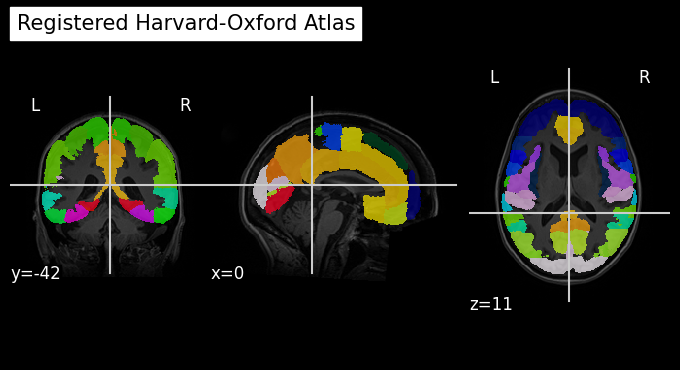

In [9]:
# Fetch the atlas (cortical or subcortical)

# atlas = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')  # 1mm resolution
# atlas_img = atlas.maps

# Fetch the cortical atlas
atlas_cortex = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')
atlas_img_cortex = atlas_cortex.maps

# Resample the atlas to match the anatomical image
resampled_atlas = resample_to_img(atlas_img_cortex, anatomical_nii, interpolation='nearest')
# resampled_atlas = resample_to_img(atlas_img, anatomical_nii , interpolation='nearest')

# Save the new resampled atlas
resampled_atlas.to_filename("registered_atlas.nii.gz")
plot_roi(resampled_atlas, bg_img=anatomical_nii, title="Registered Harvard-Oxford Atlas")

[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/fsl

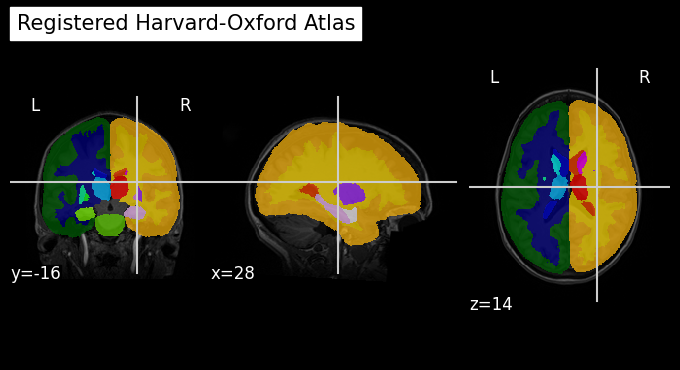

In [10]:
# Fetch the sub-cortical atlas
atlas_subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
atlas_img_subcortical = atlas_subcortical.filename

# Resample the atlas to match the anatomical image
resampled_atlas = resample_to_img(atlas_img_subcortical, anatomical_nii, interpolation='nearest')
# resampled_atlas = resample_to_img(atlas_img, anatomical_nii , interpolation='nearest')

# Save the new resampled atlas
resampled_atlas.to_filename("registered_atlas.nii.gz")
plot_roi(resampled_atlas, bg_img=anatomical_nii, title="Registered Harvard-Oxford Atlas")


#### Defining Regions of Interest

In [11]:
# Convert the resampled atlas image to a NumPy array
atlas_data = resampled_atlas.get_fdata()

# Extract unique region labels from the atlas
roi_labels = np.unique(atlas_data)[1:]  # Ignore background (0)


In [12]:
fmri_data.shape


(64, 64, 34, 300)

In [13]:
atlas_data.shape

(256, 256, 192)

In [14]:
np.where(atlas_data == 1.0)

(array([ 67,  67,  67, ..., 129, 129, 129]),
 array([105, 106, 107, ..., 163, 163, 164]),
 array([ 76,  77,  77, ..., 103, 104, 104]))

In [15]:
# Step 1: Resample the atlas to match the spatial dimensions of fmri_data (64, 64, 34)
# Determine the scaling factors for each spatial dimension
scaling_factors = np.array(fmri_data.shape[:3]) / np.array(atlas_data.shape)

# Resample the atlas using the scaling factors (linear interpolation)
resampled_atlas = zoom(atlas_data, scaling_factors, order=1)  # Using linear interpolation

# Round and cast the resampled atlas to integers
resampled_atlas = np.round(resampled_atlas).astype(int)

# Step 2: Extract unique region labels from the resampled atlas (skip background 0)
roi_labels = np.unique(resampled_atlas)[np.unique(resampled_atlas) > 0]

# Create a dictionary to store extracted time series for each ROI
roi_time_series = {}

# Step 3: Extract fMRI time series for each ROI
for roi in tqdm(roi_labels, desc="Processing ROIs"):
    # Get the voxel indices for the current ROI in the resampled atlas
    roi_voxels = np.where(resampled_atlas == roi)

    # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
    # Extract the fMRI signal corresponding to these voxels for each time point
    roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)

    # Store the resulting time series for the current ROI
    roi_time_series[roi] = roi_signal


Processing ROIs: 100%|██████████| 21/21 [00:00<00:00, 235.89it/s]


In [16]:
roi_labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [17]:
roi_time_series

{1: array([720.64699828, 719.03979417, 719.01132075, 718.87787307,
        720.16123499, 720.10806175, 721.27135506, 720.07924528,
        721.7238422 , 722.99245283, 721.73584906, 720.70428816,
        718.232247  , 719.69639794, 719.07169811, 718.39622642,
        717.82813036, 717.96363636, 718.56672384, 718.80686106,
        718.65523156, 719.66655232, 718.91492281, 720.48953688,
        720.73584906, 719.3890223 , 719.41269297, 719.97118353,
        719.83979417, 719.67958834, 718.31972556, 718.59108062,
        718.55574614, 719.14991424, 719.6109777 , 719.78524871,
        719.36809605, 718.78456261, 718.44288165, 718.71183533,
        717.70428816, 718.29982847, 718.90222985, 719.00445969,
        718.58765009, 719.1728988 , 719.49090909, 718.62332762,
        719.20789022, 719.11012007, 719.02161235, 718.6922813 ,
        719.14168096, 719.13138937, 719.52349914, 721.69639794,
        720.1077187 , 719.44288165, 719.36157804, 721.56295026,
        720.88953688, 719.26174957, 7

In [18]:
# Convert to DataFrame
roi_df = pd.DataFrame(roi_time_series)


In [19]:
roi_df.head()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,720.646998,808.780566,789.577778,628.645963,715.533333,574.344828,735.175676,524.631090,671.428571,742.2875,...,692.445239,779.448363,772.621053,611.491803,828.279070,457.205882,393.333333,429.090909,429.000000,469.2
1,719.039794,807.074528,782.622222,627.652174,713.988889,575.879310,731.202703,522.902552,669.233083,737.6625,...,690.184419,776.482268,764.094737,608.286885,820.255814,456.750000,391.866667,428.477273,429.814815,475.4
2,719.011321,807.540943,779.444444,627.801242,713.866667,576.267241,730.932432,523.329466,668.586466,736.6250,...,689.855476,775.753702,761.663158,610.081967,818.627907,459.014706,391.366667,427.363636,426.444444,475.6
3,718.877873,806.840189,778.681481,628.596273,712.688889,574.034483,731.540541,522.777262,669.330827,736.5125,...,689.744825,775.428488,760.905263,611.426230,816.046512,457.750000,394.400000,429.250000,432.222222,484.2
4,720.161235,809.560377,779.266667,632.857143,718.933333,577.681034,734.864865,524.860789,668.383459,732.5250,...,691.214528,777.137373,761.600000,611.409836,824.581395,459.294118,395.500000,432.272727,440.037037,494.6


In [20]:
roi_df

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,720.646998,808.780566,789.577778,628.645963,715.533333,574.344828,735.175676,524.631090,671.428571,742.2875,...,692.445239,779.448363,772.621053,611.491803,828.279070,457.205882,393.333333,429.090909,429.000000,469.2
1,719.039794,807.074528,782.622222,627.652174,713.988889,575.879310,731.202703,522.902552,669.233083,737.6625,...,690.184419,776.482268,764.094737,608.286885,820.255814,456.750000,391.866667,428.477273,429.814815,475.4
2,719.011321,807.540943,779.444444,627.801242,713.866667,576.267241,730.932432,523.329466,668.586466,736.6250,...,689.855476,775.753702,761.663158,610.081967,818.627907,459.014706,391.366667,427.363636,426.444444,475.6
3,718.877873,806.840189,778.681481,628.596273,712.688889,574.034483,731.540541,522.777262,669.330827,736.5125,...,689.744825,775.428488,760.905263,611.426230,816.046512,457.750000,394.400000,429.250000,432.222222,484.2
4,720.161235,809.560377,779.266667,632.857143,718.933333,577.681034,734.864865,524.860789,668.383459,732.5250,...,691.214528,777.137373,761.600000,611.409836,824.581395,459.294118,395.500000,432.272727,440.037037,494.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,725.955746,807.667170,764.096296,627.857143,699.666667,572.198276,735.189189,531.814385,680.541353,753.1000,...,696.199849,778.714536,762.800000,608.631148,798.465116,453.044118,380.066667,441.227273,455.592593,446.8
296,725.790395,807.303396,764.044444,627.416149,701.700000,573.956897,735.864865,533.004640,677.518797,755.0875,...,695.517877,778.454209,762.578947,608.639344,798.837209,454.102941,383.900000,434.954545,445.814815,450.8
297,725.625729,806.826981,764.259259,628.677019,700.311111,572.086207,737.081081,533.426914,677.857143,752.4125,...,695.687241,778.276306,762.957895,609.655738,796.697674,455.397059,379.766667,435.818182,458.481481,452.6
298,725.849400,808.180000,765.155556,629.881988,701.833333,573.758621,737.081081,532.329466,681.030075,754.0625,...,696.225066,779.102299,762.757895,609.122951,798.255814,453.720588,380.566667,438.795455,449.555556,444.0


In [21]:
roi_df.iloc[:, 0]

0      720.646998
1      719.039794
2      719.011321
3      718.877873
4      720.161235
          ...    
295    725.955746
296    725.790395
297    725.625729
298    725.849400
299    725.753002
Name: 1, Length: 300, dtype: float64

In [ ]:
# Save as CSV
roi_df.to_csv("roi_activity.csv", index=False)


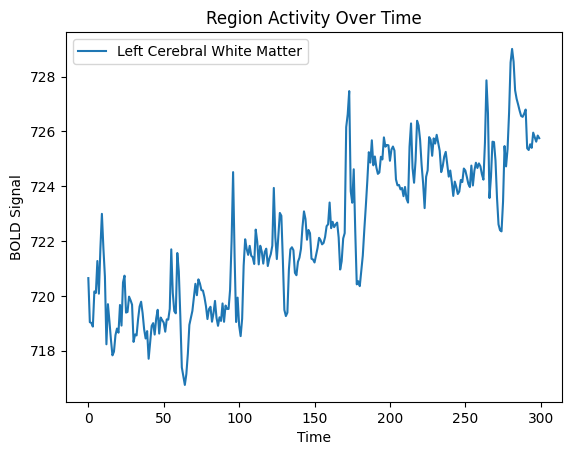

In [54]:
# Plot an example ROI signal
plt.plot(roi_df.iloc[:, 0], label = atlas_subcortical.labels[1])  # Plot the first region
plt.xlabel("Time")
plt.ylabel("BOLD Signal")
plt.title("Region Activity Over Time")
plt.legend()
plt.show()

In [24]:
index = 0

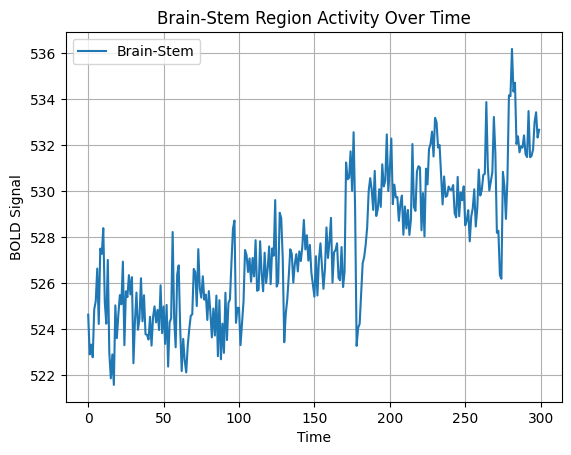

In [59]:
# Plot an example ROI signal
plt.plot(roi_df.iloc[:, index], label = atlas_subcortical.labels[index+1])  # Plot the first region
plt.xlabel("Time")
plt.ylabel("BOLD Signal")
plt.title(f"{atlas_subcortical.labels[index+1]} Region Activity Over Time")
plt.legend()
plt.grid(True)
plt.show()
index +=1
index %= roi_df.shape[1]

### Calculating the ALFF/fALFF and the Bold Variability

In [ ]:
index = 0

In [ ]:
roi_df.iloc[:, index]

In [ ]:
# Parameters
TR = 2 # Repetition time (in seconds)
low_freq_band = (0.01, 0.1) # Low-frequency range for ALFF (Hz)
n_timepoints = roi_df.shape[0]
frequencies = fftfreq(n_timepoints, d=TR)
fft_data = fft(roi_df.iloc[:, index], axis=-1)


In [ ]:
roi_df.iloc[:, 0]

In [ ]:

# Create a mask for the low-frequency band
low_freq_mask = np.logical_and(frequencies >= low_freq_band[0], frequencies <= low_freq_band[1])

# Compute the ALFF: average amplitude in the low-frequency band
alff = np.abs(fft_data)[..., low_freq_mask].mean(axis=-1)

# For fALFF: Compute the total power in the 0.01-0.25 Hz range
total_power = np.abs(fft_data)[..., (frequencies >= 0.01) & (frequencies <= 0.25)].sum(axis=-1)

# Compute fALFF: Normalized ALFF
falff = alff / total_power


In [ ]:
# BOLD Signal Variability (e.g., using Coefficient of Variation)
cv = np.std(roi_df.iloc[:, index]) / np.mean(roi_df.iloc[:, index])

In [ ]:
falff

In [ ]:
cv

# Next Steps


- [ ] Creating region_activities all_brains:  a list of dictionaries, where each dictionary maps region names to activity levels
- [ ] regions: atlas.labels[1:]
- [ ] brains_fmri: exists
- [ ] Improvement: increase granularity by having multiple signals from regions where regions correspond to Link-sized regions with 1024 BOLD temporal signals
- [ ] Compute the Activity Difference
- [ ] Create the Graph
- [ ] Export the graph data
- [ ] visualize
- [ ] host visualization on github pages
- [ ] include sub-cortical regions
- [ ] cluster the data by age, handedness, sex, and education
- [ ] cluster by health, MCI, and Demented
- [ ] evaluate level of stimulation to apply to achieve normal cognitive status
- [ ] simulate applying stimulation to MCI or Demented to achieve Healthy Cognitive Function


## Acquiring All Signals For all Brains

In [73]:
from nilearn import datasets, plotting

# Fetch the Harvard-Oxford sub-cortical atlas (probabilistic)
atlas_filename = "../data/atlas/NMS-SNc-atlas-master/SN_R_probatlas27_50.nii.gz"

# Plot the atlas to view the regions including substantia nigra
plotting.plot_roi(atlas_filename, title="Harvard-Oxford Sub-cortical Atlas", display_mode="ortho", draw_cross=True, output_file="../img/brain_atlas.png")
plotting.show()

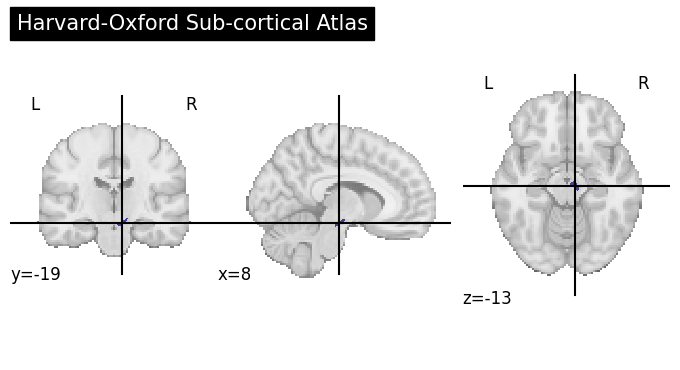

In [78]:
plotting.plot_roi(atlas_filename, title="Harvard-Oxford Sub-cortical Atlas", display_mode="ortho", draw_cross=True)

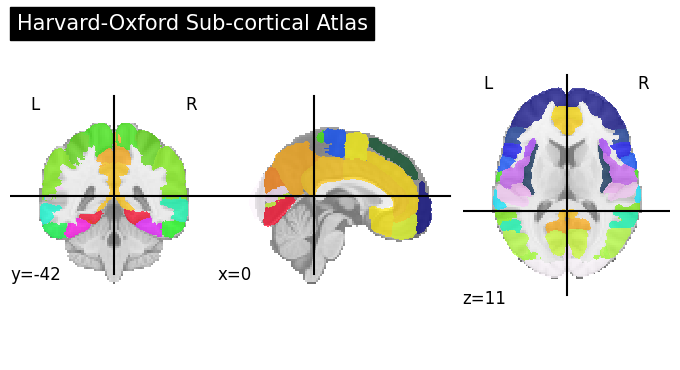

In [80]:
plotting.plot_roi(atlas_img_cortex, title="Harvard-Oxford Sub-cortical Atlas", display_mode="ortho", draw_cross=True)


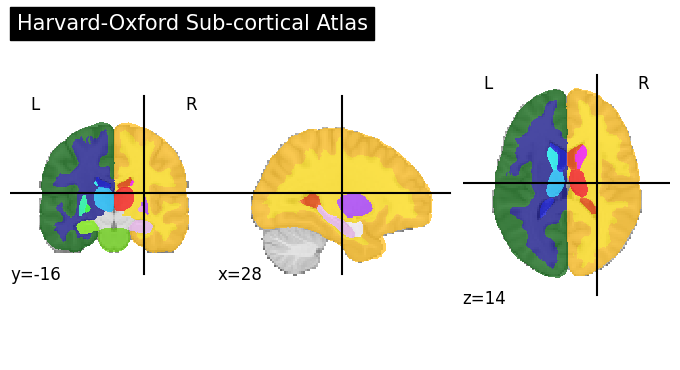

In [79]:
plotting.plot_roi(atlas_img_subcortical, title="Harvard-Oxford Sub-cortical Atlas", display_mode="ortho", draw_cross=True)


In [71]:

# Load the image
image_path = "../img/brain_atlas.png"
image = Image.open(image_path)

# Use pytesseract to extract text from the image
extracted_text = pytesseract.image_to_string(image)

# Print the extracted text to see the output
print(extracted_text)

# Example of extracted text
extracted_text = "Some other information x = 8, y = -19, z = -13 more text."

# Regex to find the x, y, z coordinates
coordinates = re.findall(r"x\s*=\s*(-?\d+),\s*y\s*=\s*(-?\d+),\s*z\s*=\s*(-?\d+)", extracted_text)

if coordinates:
    x, y, z = map(int, coordinates[0])  # Convert extracted coordinates to integers
    print(f"Extracted coordinates: x = {x}, y = {y}, z = {z}")

Harvard-Oxford Sub-cortical Atlas

y=-19 x=8 °

z=-13

Extracted coordinates: x = 8, y = -19, z = -13


In [76]:
# Fetch the atlas (cortical or subcortical)
atlas_cortex = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')  # 1mm resolution
atlas_img_cortex = atlas_cortex.filename

# Fetch the sub-cortical atlas
atlas_subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
atlas_img_subcortical = atlas_subcortical.filename


[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/fsl

[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/fsl

In [37]:
region_coordinate_df = pd.DataFrame(['Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate Gyrus', 'Cingulate Gyrus, anterior division', 'Cingulate Gyrus, posterior division', 'Precuneous Cortex', 'Cuneal Cortex', 'Frontal Orbital Cortex', 'Parahippocampal Gyrus, anterior division', 'Parahippocampal Gyrus, posterior division', 'Lingual Gyrus', 'Temporal Fusiform Cortex, anterior division', 'Temporal Fusiform Cortex, posterior division', 'Temporal Occipital Fusiform Cortex', 'Occipital Fusiform Gyrus', 'Frontal Opercular Cortex', 'Central Opercular Cortex', 'Parietal Opercular Cortex', 'Planum Polare', "Heschl's Gyrus (includes H1 and H2)", 'Planum Temporale', 'Supracalcarine Cortex', 'Occipital Pole', 'Left Cerebral White Matter', 'Left Cerebral Cortex', 'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens', 'Substantia Nigra Right', 'Substantia Nigra Left'], columns=["Region"])

In [83]:
atlas_filename

'../data/atlas/NMS-SNc-atlas-master/SN_R_probatlas27_50.nii.gz'

In [86]:
atlas_data = nib.load(atlas_filename).get_fdata()

In [ ]:
atlas_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [91]:
atlas.labels[1:]

['Left Cerebral White Matter',
 'Left Cerebral Cortex',
 'Left Lateral Ventricle',
 'Left Thalamus',
 'Left Caudate',
 'Left Putamen',
 'Left Pallidum',
 'Brain-Stem',
 'Left Hippocampus',
 'Left Amygdala',
 'Left Accumbens',
 'Right Cerebral White Matter',
 'Right Cerebral Cortex',
 'Right Lateral Ventricle',
 'Right Thalamus',
 'Right Caudate',
 'Right Putamen',
 'Right Pallidum',
 'Right Hippocampus',
 'Right Amygdala',
 'Right Accumbens']

In [82]:
import nibabel as nib
from nilearn import plotting
from nilearn import image
import numpy as np

# Load an MNI template (standard brain template)
mni_template = nib.load(atlas_filename)  # Use the path to the MNI template file
data = mni_template.get_fdata()

# Define a function to extract coordinates for specific brain regions from an atlas
def get_coordinates(region_name):
    # Load the brain atlas (ensure you have an atlas like Harvard-Oxford or similar)
    atlas_path = atlas_filename  # Replace with the actual atlas file path
    atlas = nib.load(atlas_path)
    atlas_data = atlas.get_fdata()

    # Lookup for the region in the atlas (you would need to map region names to specific voxel values)
    # Assuming the region is encoded by a unique value in the atlas
    region_label = None  # Get the corresponding label (this depends on your atlas)
    region_indices = np.where(atlas_data == region_label)

    # Convert voxel indices to MNI space (you can use nibabel for this)
    mni_coords = nib.affines.apply_affine(mni_template.affine, np.array(region_indices).T)

    return mni_coords

# Example: Get coordinates for the 'Frontal Pole'
coordinates = get_coordinates('Substantia Nigra Right')
print(f"Coordinates for 'Frontal Pole': {coordinates}")


Coordinates for 'Frontal Pole': []


In [44]:
x = np.array([0 for index in range(71)])
y = np.array([0 for index in range(71)])
z = np.array([0 for index in range(71)])

In [45]:
region_coordinate_df["x"] = x
region_coordinate_df["y"] = y
region_coordinate_df["z"] = z

In [57]:
region_coordinate_df.iloc[69, :]

Region    Substantia Nigra Right
x                              0
y                              0
z                              0
Name: 69, dtype: object

In [60]:
region = "Substantia Nigra Right"

In [62]:
region_coordinate_df.loc[region_coordinate_df["Region"] == region, :]

,Region,x,y,z
69,Substantia Nigra Right,0,0,0


In [ ]:
atlas_filename = datasets.fetch_atlas_harvard_oxford('sub-cortical')['filename']

ValueError: Invalid atlas name: sub-cortical. Please choose an atlas among:
cort-maxprob-thr0-1mm
cort-maxprob-thr0-2mm
cort-maxprob-thr25-1mm
cort-maxprob-thr25-2mm
cort-maxprob-thr50-1mm
cort-maxprob-thr50-2mm
cort-prob-1mm
cort-prob-2mm
cortl-maxprob-thr0-1mm
cortl-maxprob-thr0-2mm
cortl-maxprob-thr25-1mm
cortl-maxprob-thr25-2mm
cortl-maxprob-thr50-1mm
cortl-maxprob-thr50-2mm
cortl-prob-1mm
cortl-prob-2mm
sub-maxprob-thr0-1mm
sub-maxprob-thr0-2mm
sub-maxprob-thr25-1mm
sub-maxprob-thr25-2mm
sub-maxprob-thr50-1mm
sub-maxprob-thr50-2mm
sub-prob-1mm
sub-prob-2mm

In [33]:
atlas_filename

'../data/atlas/NMS-SNc-atlas-master/SN_L_probatlas27_50.nii.gz'

In [32]:
import nibabel as nib
import numpy as np

# Load the atlas NIfTI image
atlas_img = nib.load(atlas_filename)

# Get the image data as a numpy array
atlas_data = atlas_img.get_fdata()

# Find the nonzero voxel coordinates (i.e., where the atlas has nonzero values)
voxel_coords = np.argwhere(atlas_data > 0)

# Convert voxel coordinates to real-world (MNI or scanner) space
affine = atlas_img.affine
world_coords = nib.affines.apply_affine(affine, voxel_coords)

# Print first few coordinates
print(world_coords[:10])


[[ -2. -21. -18.]
 [ -2. -21. -17.]
 [ -2. -20. -17.]
 [ -2. -20. -16.]
 [ -2. -19. -16.]
 [ -2. -19. -15.]
 [ -3. -22. -19.]
 [ -3. -22. -18.]
 [ -3. -21. -19.]
 [ -3. -21. -18.]]


In [30]:

# Load the AAL Atlas
atlas = datasets.fetch_atlas_aal()

[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/aal_SPM12

[fetch_single_file] Downloading data from https://www.gin.cnrs.fr/AAL_files/aal_for_SPM12.tar.gz ...

[fetch_single_file] Error while fetching file aal_for_SPM12.tar.gz; dataset fetching aborted.

SSLError: HTTPSConnectionPool(host='www.gin.cnrs.fr', port=443): Max retries exceeded with url: /AAL_files/aal_for_SPM12.tar.gz (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'www.gin.cnrs.fr'. (_ssl.c:1007)")))

In [29]:
pd.DataFrame(flat_list).to_csv("temp.csv", index=False)

In [23]:
matches = [(i, item) for i, item in enumerate(flat_list) if "Substantia Nigra" in item]

print(matches)  
# Output: [(2, 'Substantia Nigra Left'), (4, 'Substantia Nigra Right')]


[]


In [5]:
atlas_filename = datasets.fetch_atlas_harvard_oxford('sub-cortical')['filename']

ValueError: Invalid atlas name: sub-cortical. Please choose an atlas among:
cort-maxprob-thr0-1mm
cort-maxprob-thr0-2mm
cort-maxprob-thr25-1mm
cort-maxprob-thr25-2mm
cort-maxprob-thr50-1mm
cort-maxprob-thr50-2mm
cort-prob-1mm
cort-prob-2mm
cortl-maxprob-thr0-1mm
cortl-maxprob-thr0-2mm
cortl-maxprob-thr25-1mm
cortl-maxprob-thr25-2mm
cortl-maxprob-thr50-1mm
cortl-maxprob-thr50-2mm
cortl-prob-1mm
cortl-prob-2mm
sub-maxprob-thr0-1mm
sub-maxprob-thr0-2mm
sub-maxprob-thr25-1mm
sub-maxprob-thr25-2mm
sub-maxprob-thr50-1mm
sub-maxprob-thr50-2mm
sub-prob-1mm
sub-prob-2mm

In [12]:
# Fetch the atlas (cortical or subcortical)
atlas_cortex = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')  # 1mm resolution
atlas_img_cortex = atlas_cortex.filename

# Fetch the sub-cortical atlas
atlas_subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
atlas_img_subcortical = atlas_subcortical.filename

# Load the Harvard-Oxford Sub-cortical Atlas
# from nilearn import datasets
# atlas_filename = datasets.fetch_atlas_harvard_oxford('sub-cortical')['filename']

# Plot the Harvard-Oxford Sub-cortical Atlas overlaid on the fMRI data
# plotting.plot_roi(atlas_filename, bg_img=fmri_data, title="Harvard-Oxford Sub-cortical Atlas")


atlas_labels = atlas_cortex.labels[1:] + atlas_subcortical.labels[1:]

# Root directory is 'data'
root_dir = '../data'

# Glob all files that end in .nii under any 'func' directory (in nested subfolders)
func_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*.nii.gz'), recursive=True)

# Filter out files that contain the word 'mask' from the func_files list
func_files_without_mask = [file for file in func_files if 'mask' not in file]

# Glob all files that end in .nii under any 'anat' directory (in nested subfolders)
anat_files = glob.glob(os.path.join(root_dir, '**', 'anat', '**', '*.nii.gz'), recursive=True)

# Glob all files that contain the word "mask" that end in .nii and are located under any 'func' directory (in nested subfolders)
func_mask_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*mask*.nii.gz'), recursive=True)

# Output the results
print("Func files without mask:", func_files_without_mask)
print("Anat files:", anat_files)
print("Func mask files:", func_mask_files)

[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/fsl

[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/fsl

Func files without mask: ['../data/sub-0270/ses-01/func/sub-0270_ses-01_task-rest_bold.nii.gz', '../data/sub-0205/ses-01/func/sub-0205_ses-01_task-rest_bold.nii.gz', '../data/sub-0231/ses-01/func/sub-0231_ses-01_task-rest_bold.nii.gz', '../data/sub-0240/ses-01/func/sub-0240_ses-01_task-rest_bold.nii.gz', '../data/sub-0238/ses-01/func/sub-0238_ses-01_task-rest_bold.nii.gz', '../data/sub-0252/ses-01/func/sub-0252_ses-01_task-rest_bold.nii.gz', '../data/sub-2132/ses-01/func/sub-2132_ses-01_task-rest_bold.nii.gz', '../data/sub-2122/ses-01/func/sub-2122_ses-01_task-rest_bold.nii.gz', '../data/sub-0272/ses-01/func/sub-0272_ses-01_task-rest_bold.nii.gz', '../data/sub-2130/ses-01/func/sub-2130_ses-01_task-rest_bold.nii.gz', '../data/sub-2145/ses-01/func/sub-2145_ses-01_task-rest_bold.nii.gz', '../data/sub-0264/ses-01/func/sub-0264_ses-01_task-rest_bold.nii.gz', '../data/sub-2134/ses-01/func/sub-2134_ses-01_task-rest_bold.nii.gz', '../data/sub-0202/ses-01/func/sub-0202_ses-01_task-rest_bold.nii

In [ ]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [ ]:
len(brains_anatomical)

In [ ]:
len(brains_fmri)

In [ ]:
# Create Bold Signals For All Subcortical and Cortical Regions
for person in tqdm(range(len(brains_fmri))):
    bold_signal_dir = os.path.dirname(os.path.dirname(brains_fmri[person]))
    subject_name = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(brains_fmri[person]))))
    # Example: Load the first brain's fMRI and anatomical data
    fmri_data, fmri_affine = load_nii(brains_fmri[person])  # Shape: (x, y, z, t)
    anatomical_data, anatomical_affine = load_nii(brains_anatomical[person])  # Shape: (x, y, z)
    anatomical_nii = nib.load(brains_anatomical[person])
    
    # Resample the atlas to match the anatomical image (cortical)
    resampled_atlas_cortex = resample_to_img(atlas_img_cortex, anatomical_nii , interpolation='nearest')
    resampled_atlas_subcortex = resample_to_img(atlas_img_subcortical, anatomical_nii , interpolation='nearest')
    
    # Save the new resampled atlas
    # resampled_atlas.to_filename("registered_atlas.nii.gz")
    
    # Convert the resampled atlas image to a NumPy array
    atlas_data_cortex = resampled_atlas_cortex.get_fdata()
    atlas_data_subcortex = resampled_atlas_subcortex.get_fdata()
    
    # Extract unique region labels from the atlas
    roi_labels_cortex = np.unique(atlas_data_cortex)[1:]  # Ignore background (0)
    roi_labels_subcortex = np.unique(atlas_data_subcortex)[1:]  # Ignore background (0)roi_labels_cortex = np.unique(atlas_data_cortex)[1:]  # Ignore background (0)

    # Step 1: Resample the atlas to match the spatial dimensions of fmri_data (64, 64, 34)
    # Determine the scaling factors for each spatial dimension
    scaling_factors = np.array(fmri_data.shape[:3]) / np.array(atlas_data_cortex.shape)

    # Resample the atlas using the scaling factors (linear interpolation)
    resampled_atlas_cortex = zoom(atlas_data_cortex, scaling_factors, order=1)  # Using linear interpolation
    resampled_atlas_subcortex = zoom(atlas_data_subcortex, scaling_factors, order=1) # Using linear inerpolation

    # Round and cast the resampled atlas to integers
    resampled_atlas_cortex = np.round(resampled_atlas_cortex).astype(int)
    resampled_atlas_subcortex = np.round(resampled_atlas_subcortex).astype(int)

    # Step 2: Extract unique region labels from the resampled atlas (skip background 0)
    # roi_labels = np.unique(resampled_atlas)[np.unique(resampled_atlas) > 0]

    # Create a dictionary to store extracted time series for each ROI
    roi_time_series = {}

    # Step 3: Extract fMRI time series for each ROI
    for roi in tqdm(roi_labels_cortex, desc="Processing ROIs"):
        # Get the voxel indices for the current ROI in the resampled atlas
        roi_voxels = np.where(resampled_atlas_cortex == roi)

        # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
        # Extract the fMRI signal corresponding to these voxels for each time point
        roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)

        # Store the resulting time series for the current ROI
        roi_time_series[roi] = roi_signal

    # Convert to DataFrame
    roi_cortex_df = pd.DataFrame(roi_time_series)

    # Create a dictionary to store extracted time series for each ROI
    roi_time_series = {}

    # Step 3: Extract fMRI time series for each ROI
    for roi in tqdm(roi_labels_subcortex, desc="Processing ROIs"):
        # Get the voxel indices for the current ROI in the resampled atlas
        roi_voxels = np.where(resampled_atlas_subcortex == roi)

        # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
        # Extract the fMRI signal corresponding to these voxels for each time point
        roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)

        # Store the resulting time series for the current ROI
        roi_time_series[roi] = roi_signal

    # Convert to DataFrame
    roi_subcortex_df = pd.DataFrame(roi_time_series)
    roi_df = pd.concat([roi_cortex_df, roi_subcortex_df], axis=1)
    roi_df.columns = atlas_labels

    f_path = bold_signal_dir + '/' + subject_name + "_roi_BOLD_activity.csv"

    # Save as CSV
    bold_signal_dir
    # roi_df.to_csv(f_path, index=False)


## Collecting CSV of BOLD Activity

In [ ]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [ ]:
BOLD_activity_csv_list =[f for f in glob.glob("data/**/*.csv", recursive=True) if "dataframes" not in f ]

In [ ]:
BOLD_activity_csv_list

In [ ]:
# Fetch the atlas (cortical or subcortical)
atlas_cortex = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')  # 1mm resolution
atlas_img_cortex = atlas_cortex.filename

# Fetch the sub-cortical atlas
atlas_subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
atlas_img_subcortical = atlas_subcortical.filename

atlas_labels = atlas_cortex.labels[1:] + atlas_subcortical.labels[1:]
atlas_labels

In [ ]:
BOLD_activity_df_list = []
for person in BOLD_activity_csv_list:
    BOLD_activity_df_list.append(pd.read_csv(person))

##### Computing fractional Amplitude Low Frequency Fluctuations & Coefficient of Variance

In [ ]:
fALFF_df = pd.DataFrame(columns=["Subject"] + atlas_labels)
cv_df = pd.DataFrame(columns=["Subject"] + atlas_labels)

In [ ]:
# Parameters
TR = 2 # Repetition time (in seconds)
low_freq_band = (0.01, 0.1) # Low-frequency range for ALFF (Hz)
n_timepoints = 300
frequencies = fftfreq(n_timepoints, d=TR)
# Create a mask for the low-frequency band
low_freq_mask = np.logical_and(frequencies >= low_freq_band[0], frequencies <= low_freq_band[1])

In [ ]:
fft(BOLD_activity_df_list[0].iloc[:, 1], axis=-1)

In [ ]:
for temp_df in BOLD_activity_df_list:
    for region in range(len(temp_df.columns)):
        # print(temp_df.iloc[:, region])
        print(temp_df.columns)

In [ ]:
temp_df.columns

In [ ]:
temp_df.iloc[:]

In [ ]:
for temp_df in BOLD_activity_df_list:
    for region in range(len(temp_df.columns)):
        print(temp_df.iloc[:, region])
        print(type(region))
        # fft_data = fft(temp_df.iloc[:, region], axis=-1)

In [ ]:
# Calculate Frequencies and CV
person = 0
for temp_df in tqdm(BOLD_activity_df_list):
    subject_name = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(brains_fmri[person]))))
    fALFF_values = []
    cv_values = []
    for region in range(len(temp_df.columns)):
        fft_data = fft(temp_df.iloc[:, region], axis=-1)
        
        # Compute the ALFF: average amplitude in the low-frequency band
        alff = np.abs(fft_data)[..., low_freq_mask].mean(axis=-1)

        # For fALFF: Compute the total power in the 0.01-0.25 Hz range
        total_power = np.abs(fft_data)[..., (frequencies >= 0.01) & (frequencies <= 0.25)].sum(axis=-1)

        # Compute fALFF: Normalized ALFF
        falff = alff / total_power
        fALFF_values.append(falff)
        
        # BOLD Signal Variability (e.g., using Coefficient of Variation)
        cv = np.std(temp_df.iloc[:, region]) / np.mean(temp_df.iloc[:, region])
        cv_values.append(cv)
    
    # Create the new row with "Subject" and the numerical values
    new_row = {'Subject': subject_name}  # Add the string value for 'Subject'
    new_row.update(dict(zip(atlas_labels, fALFF_values)))  # Add numerical values to the other columns
    fALFF_df.loc[len(fALFF_df)] = new_row
    
    new_row = {'Subject': subject_name}
    new_row.update(dict(zip(atlas_labels, cv_values)))
    cv_df.loc[len(cv_df)] = new_row
    person+=1
        


In [ ]:
len(BOLD_activity_df_list)

In [ ]:
len(subject_name_l)

In [ ]:
df_dir = "data/dataframes/BOLD/"
for df in tqdm(range(len(BOLD_activity_df_list))):
    BOLD_activity_df_list[df].to_csv(df_dir + subject_name_l[df] + "_BOLD.csv", index=False)
    

In [ ]:
fALFF_df.head()

In [ ]:
cv_df.head()

In [ ]:
# Set the 'Subject' column as the index for easy access
fALFF_df.set_index('Subject', inplace=True)
cv_df.set_index('Subject', inplace=True)


In [ ]:
# save fALFF_df & cv df
fALFF_df.to_csv("data/dataframes/fALFF.csv")  # Save without the index
cv_df.to_csv("data/dataframes/cv_df.csv")


In [ ]:
# Acquiring subject names:
subject_name_l = []
for person in range(len(brains_fmri)):
    subject_name = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(brains_fmri[person]))))
    subject_name_l.append(subject_name)

In [ ]:
subject_name_df = pd.DataFrame(subject_name_l, columns=['Name'])

In [ ]:
subject_name_df.head()

In [ ]:
subject_name_df.to_csv("data/dataframes/subject_name_df.csv", index = False)

## Visualize the fALFF & CV

In [ ]:
# Load fALFF & CV
fALFF_df = pd.read_csv("data/dataframes/fALFF.csv", index_col=0)
cv_df = pd.read_csv("data/dataframes/cv_df.csv", index_col=0)
subject_name_df = pd.read_csv("data/dataframes/subject_name_df.csv")

In [ ]:
subject_name_df.head()

In [ ]:
fALFF_df.head()

In [ ]:
cv_df.head()

In [ ]:
BOLD_activity_df_list[0]

In [ ]:
# Create an empty bipartite graph
B = nx.Graph()

# Add nodes for subjects (bipartite set 1)
B.add_nodes_from(fALFF_df.index, bipartite=0)

# Add nodes for regions (bipartite set 2)
regions = fALFF_df.columns.tolist()  # All regions are the columns of fALFF_df
B.add_nodes_from(regions, bipartite=1)

# Add edges between subjects and regions with two distinct weights (one from fALFF_df and one from cv_df)
for subject in fALFF_df.index:
    for region in fALFF_df.columns:
        weight1 = fALFF_df.at[subject, region]  # Weight from fALFF_df
        weight2 = cv_df.at[subject, region]  # Weight from cv_df
        
        # Add an edge with two distinct weights
        B.add_edge(subject, region, weight_fALFF=weight1, weight_cv=weight2)

# Now the graph B contains bipartite nodes (subjects and regions) with edges having two distinct weights

# Example: Print the edges with weights from both dataframes
for u, v, data in B.edges(data=True):
    print(f"Edge ({u}, {v}) - Weight from fALFF_df: {data['weight_fALFF']}, Weight from cv_df: {data['weight_cv']}")


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Set positions for bipartite layout with increased spacing
pos = {}
pos.update((node, (1, index * 2.5)) for index, node in enumerate(fALFF_df.index))  # Subjects (left side)
pos.update((node, (4, index * 2.5)) for index, node in enumerate(regions))  # Regions (right side)

# Get edge weights from the fALFF_df's weight column
edge_weights = [B[u][v]['weight_fALFF'] for u, v in B.edges()]

# Normalize edge thickness for better visibility
max_weight = max(edge_weights) if edge_weights else 1  # Avoid division by zero
edge_widths = [1 + 6 * (w / max_weight) for w in edge_weights]  # Scale thickness between 1 and 7

# Normalize edge color mapping
norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
cmap = cm.Blues
edge_colors = [cmap(norm(w)) for w in edge_weights]

# Set larger figure size
plt.figure(figsize=(24, 16))  # Bigger canvas for better visibility

# Draw the bipartite graph with smaller nodes
edges = nx.draw_networkx_edges(
    B, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=cmap, alpha=0.8
)
nodes = nx.draw_networkx_nodes(B, pos, node_size=800, node_color='skyblue')  # Smaller nodes
labels = nx.draw_networkx_labels(B, pos, font_size=12, font_weight='bold')

# Add colorbar legend for edge weights
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label("Edge Weight (fALFF)", fontsize=14)

# Title
plt.title("Optimized Bipartite Graph with Improved Spacing and Smaller Nodes", fontsize=16)

# Show the plot
plt.show()



In [ ]:
# Select the region to visualize
region_to_visualize = "Frontal Pole"

# Create an empty graph
B = nx.Graph()

# Add the central brain region node
B.add_node(region_to_visualize, color='Teal', size=3000)

# Add subject nodes and edges
for subject in fALFF_df.index:
    weight1 = fALFF_df.at[subject, region_to_visualize]  # fALFF weight
    weight2 = cv_df.at[subject, region_to_visualize] if region_to_visualize in cv_df.columns else 0  # CV weight
    
    B.add_node(subject, color='green', size=1500)  # Subject nodes
    B.add_edge(subject, region_to_visualize, weight1=weight1, weight2=weight2)  # Edge with weights

# Set figure size **before drawing**
plt.figure(figsize=(18, 14))  # Larger figure size for better visibility

# Positioning: Use `spring_layout` with a **higher `k` value** to spread nodes more
pos = nx.spring_layout(B, seed=42, k=1.5)  # Increase k for wider spacing

# Draw nodes with custom sizes and colors
node_colors = [B.nodes[node]['color'] for node in B.nodes()]
node_sizes = [B.nodes[node]['size'] for node in B.nodes()]
nx.draw(B, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, font_size=12, font_weight='bold')

# Draw edges with labels (4 decimal places)
edge_labels = {
    (u, v): f"fALFF: {B[u][v]['weight1']:.4f}\nCV: {B[u][v]['weight2']:.4f}" 
    for u, v in B.edges()
}
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_size=10)

# Title
plt.title(f"Graph Representation: '{region_to_visualize}' Connected to Subjects", fontsize=14)

# Show the plot
plt.show()


# Mapping the Brain STL to the harvard-oxford atlases and identifying region coordinates

In [4]:
graph_data = "../data/graphs/cognitively_normal_pdd_stat_sign_corr_graph.json"
detailed_brain_stl = "../data/stl/brain_20human_NIH3D_detailed.stl"
less_detailed_brain_stl = "../data/stl/human_brain_NIH3D_less_detailed.stl"

In [2]:

def stl_to_nifti(stl_file, voxel_resolution=64):
    # Step 1: Load the STL file using trimesh
    mesh = trimesh.load_mesh(stl_file)
    
    # Step 2: Create a voxel grid from the mesh
    # Voxelize the mesh
    voxel_grid = mesh.voxelized(pitch=1.0/voxel_resolution)  # Create a voxel grid with a given resolution
    
    # Step 3: Convert voxel grid to a numpy array
    # Get the numpy array representing the voxel grid (1 = inside the object, 0 = outside)
    voxel_data = voxel_grid.matrix.astype(np.uint8)
    
    # Step 4: Create NIFTI image from the numpy array
    nifti_img = nib.Nifti1Image(voxel_data, np.eye(4))  # Identity matrix for no transformation
    
    # Step 5: Save the NIFTI image
    nifti_file = stl_file.replace('.stl', '.nii')
    nib.save(nifti_img, nifti_file)
    print(f"Saved NIFTI file as {nifti_file}")

# Example usage
# stl_to_nifti(detailed_brain_stl, voxel_resolution=64)


In [4]:
stl_file = detailed_brain_stl
voxel_resolution=256


In [8]:

# Step 1: Load the STL file using trimesh
mesh = trimesh.load_mesh(stl_file)


In [9]:
mesh

<trimesh.Trimesh(vertices.shape=(188749, 3), faces.shape=(377701, 3))>

In [ ]:


# Example usage
stl_to_nifti(less_detailed_brain_stl, voxel_resolution=256, target_faces=50000)


Simplified mesh saved as ../data/stl/human_brain_NIH3D_less_detailed_simplified.stl
Saved NIFTI file as ../data/stl/human_brain_NIH3D_less_detailed.nii


In [8]:
stl_nifti = "../data/stl/human_brain_NIH3D_less_detailed.nii"

In [10]:
nifti_img = nib.load(stl_nifti)

In [14]:
# Fetch the atlas (cortical or subcortical)
atlas_cortex = fetch_atlas_harvard_oxford('cort-maxprob-thr25-1mm')  # 1mm resolution
atlas_img_cortex = atlas_cortex.filename

# Fetch the sub-cortical atlas
atlas_subcortical = fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
atlas_img_subcortical = atlas_subcortical.filename

atlas_sn_l = "../data/atlas/NMS-SNc-atlas-master/SN_L_probatlas27_50.nii.gz"
atlas_sn_r = "../data/atlas/NMS-SNc-atlas-master/SN_R_probatlas27_50.nii.gz"

[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/fsl

[get_dataset_dir] Dataset found in /home/linux-pc/nilearn_data/fsl

In [15]:

atlas_labels = atlas_cortex.labels[1:] + atlas_subcortical.labels[1:]


In [16]:
atlas_labels.append("Substantia Nigria Left")
atlas_labels.append("Substantia Nigria Right")

In [17]:
# Root directory is 'data'
root_dir = '../data'

# Glob all files that end in .nii under any 'func' directory (in nested subfolders)
func_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*.nii.gz'), recursive=True)

# Filter out files that contain the word 'mask' from the func_files list
func_files_without_mask = [file for file in func_files if 'mask' not in file]

# Glob all files that end in .nii under any 'anat' directory (in nested subfolders)
anat_files = glob.glob(os.path.join(root_dir, '**', 'anat', '**', '*.nii.gz'), recursive=True)

# Glob all files that contain the word "mask" that end in .nii and are located under any 'func' directory (in nested subfolders)
func_mask_files = glob.glob(os.path.join(root_dir, '**', 'func', '**', '*mask*.nii.gz'), recursive=True)

# Output the results
print("Func files without mask:", func_files_without_mask)
print("Anat files:", anat_files)
print("Func mask files:", func_mask_files)

Func files without mask: ['../data/sub-0270/ses-01/func/sub-0270_ses-01_task-rest_bold.nii.gz', '../data/sub-0205/ses-01/func/sub-0205_ses-01_task-rest_bold.nii.gz', '../data/sub-0231/ses-01/func/sub-0231_ses-01_task-rest_bold.nii.gz', '../data/sub-0240/ses-01/func/sub-0240_ses-01_task-rest_bold.nii.gz', '../data/sub-0238/ses-01/func/sub-0238_ses-01_task-rest_bold.nii.gz', '../data/sub-0252/ses-01/func/sub-0252_ses-01_task-rest_bold.nii.gz', '../data/sub-2132/ses-01/func/sub-2132_ses-01_task-rest_bold.nii.gz', '../data/sub-2122/ses-01/func/sub-2122_ses-01_task-rest_bold.nii.gz', '../data/sub-0272/ses-01/func/sub-0272_ses-01_task-rest_bold.nii.gz', '../data/sub-2130/ses-01/func/sub-2130_ses-01_task-rest_bold.nii.gz', '../data/sub-2145/ses-01/func/sub-2145_ses-01_task-rest_bold.nii.gz', '../data/sub-0264/ses-01/func/sub-0264_ses-01_task-rest_bold.nii.gz', '../data/sub-2134/ses-01/func/sub-2134_ses-01_task-rest_bold.nii.gz', '../data/sub-0202/ses-01/func/sub-0202_ses-01_task-rest_bold.nii

In [18]:
# Load the 4D fMRI data and 3D anatomical data for each brain
brains_fmri = func_files_without_mask
brains_anatomical = anat_files

In [21]:
# Load fMRI and anatomical data
def load_fmri_data(fmri_filepath):
    fmri_img = nib.load(fmri_filepath)
    fmri_data = fmri_img.get_fdata()
    return fmri_data

def load_anatomical_data(anatomical_filepath):
    anatomical_img = nib.load(anatomical_filepath)
    anatomical_data = anatomical_img.get_fdata()
    return anatomical_data

def load_nii(file_path):
    """Load .nii file using nibabel and return data as numpy array."""
    nii_data = nib.load(file_path)
    return nii_data.get_fdata(), nii_data.affine

In [34]:
anatomical_nii = nib.load(brains_anatomical[0])

In [43]:
# Resample the atlas to match the anatomical image (cortical)
resampled_atlas_cortex = resample_to_img(atlas_img_cortex, anatomical_nii , interpolation='nearest')
resampled_atlas_subcortex = resample_to_img(atlas_img_subcortical, anatomical_nii , interpolation='nearest')
resampled_atlas_sn_l = resample_to_img(atlas_sn_l, anatomical_nii, interpolation="nearest")
resampled_atlas_sn_r = resample_to_img(atlas_sn_r, anatomical_nii, interpolation="nearest")

In [44]:
# Convert the resampled atlas image to a NumPy array
atlas_data_cortex = resampled_atlas_cortex.get_fdata()
atlas_data_subcortex = resampled_atlas_subcortex.get_fdata()
atlas_data_sn_l = resampled_atlas_sn_l.get_fdata()
atlas_data_sn_r = resampled_atlas_sn_r.get_fdata()

In [ ]:
# Extract unique region labels from the atlas
roi_labels_cortex = np.unique(atlas_data_cortex)[1:]  # Ignore background (0)
roi_labels_subcortex = np.unique(atlas_data_subcortex)[1:]  # Ignore background (0)roi_labels_cortex = np.unique(atlas_data_cortex)[1:]  # Ignore background (0)
roi_labels_sn_l = np.unique(atlas_data_sn_l)[1:]  # Ignore background (0)
roi_labels_sn_r = np.unique(atlas_data_sn_r)[1:]  # Ignore background (0)

In [40]:
fmri_data, fmri_affine = load_nii(brains_fmri[0])  # Shape: (x, y, z, t)

In [41]:
scaling_factors = np.array(fmri_data.shape[:3]) / np.array(atlas_data_cortex.shape)

In [ ]:
# Resample the atlas using the scaling factors (linear interpolation)
resampled_atlas_cortex = zoom(atlas_data_cortex, scaling_factors, order=1)  # Using linear interpolation
resampled_atlas_subcortex = zoom(atlas_data_subcortex, scaling_factors, order=1) # Using linear inerpolation
resampled_atlas_sn_l = zoom(atlas_data_sn_l, scaling_factors, order=1)  # Using linear interpolation
resampled_atlas_sn_r = zoom(atlas_data_sn_r, scaling_factors, order=1) # Using linear inerpolation

# Round and cast the resampled atlas to integers
resampled_atlas_cortex = np.round(resampled_atlas_cortex).astype(int)
resampled_atlas_subcortex = np.round(resampled_atlas_subcortex).astype(int)
resampled_atlas_sn_l = np.round(resampled_atlas_sn_l).astype(int)
resampled_atlas_sn_r = np.round(resampled_atlas_sn_r).astype(int)


In [53]:
len(atlas_cortex.labels[1:])

48

### Calculating Coordinates for Cortex Regions

In [152]:
# Create a dictionary to store extracted time series for each ROI
roi_time_series = {}
# Step 3: Extract fMRI time series for each ROI
for roi in tqdm(roi_labels_cortex, desc="Processing ROIs"):
    # Get the voxel indices for the current ROI in the resampled atlas
    roi_voxels = np.where(resampled_atlas_cortex == roi)
    
    # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
    # Extract the fMRI signal corresponding to these voxels for each time point
    # roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)
    x = roi_voxels[0].mean(axis=0)
    y = roi_voxels[1].mean(axis=0)
    z = roi_voxels[2].mean(axis=0)
    region_coordinates = [x, y, z] # Compute Centroid
    # Store the resulting time series for the current ROI
    roi_time_series[roi] = region_coordinates

# Convert to DataFrame
roi_cortex_df = pd.DataFrame(roi_time_series)
# Create a dictionary to store extracted time series for each ROI


Processing ROIs: 100%|██████████| 48/48 [00:00<00:00, 3597.24it/s]


In [154]:
roi_cortex_df.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0
0,32.075305,32.065104,31.322160,31.405018,30.449735,31.753555,31.266106,32.181384,32.043478,31.065574,...,32.080,31.456522,29.792453,31.288889,31.254902,32.178571,29.125000,31.854545,32.0625,31.383978
1,45.544098,33.643229,36.957169,37.216846,35.460317,34.312796,31.658263,36.985680,31.413043,27.647541,...,22.608,18.427536,35.358491,32.207407,26.803922,32.089286,28.458333,27.672727,15.4375,11.303867
2,17.024423,17.343750,23.363128,21.381720,17.661376,17.440758,22.473389,10.985680,15.271739,16.754098,...,12.072,12.376812,15.792453,16.777778,17.627451,14.357143,16.125000,16.600000,16.3750,15.220994


In [155]:
cortex_column_labels = atlas_cortex.labels[1:]

In [156]:
keys = np.arange(1, 49, step=1.0)

In [160]:
roi_cortex_columns_dict = {}
for index, region in enumerate(cortex_column_labels):
    roi_cortex_columns_dict[keys[index]] = region


In [ ]:
roi_cortex_df.rename(columns=roi_cortex_columns_dict, inplace=True)
roi_cortex_df = roi_cortex_df.T
roi_cortex_df.rename(columns = {0:"x", 1:"y", 2:"z"}, inplace=True)
roi_cortex_df.head()


,Frontal Pole,Insular Cortex,Superior Frontal Gyrus,Middle Frontal Gyrus,"Inferior Frontal Gyrus, pars triangularis","Inferior Frontal Gyrus, pars opercularis",Precentral Gyrus,Temporal Pole,"Superior Temporal Gyrus, anterior division","Superior Temporal Gyrus, posterior division",...,Temporal Occipital Fusiform Cortex,Occipital Fusiform Gyrus,Frontal Opercular Cortex,Central Opercular Cortex,Parietal Opercular Cortex,Planum Polare,Heschl's Gyrus (includes H1 and H2),Planum Temporale,Supracalcarine Cortex,Occipital Pole
x,32.075305,32.065104,31.322160,31.405018,30.449735,31.753555,31.266106,32.181384,32.043478,31.065574,...,32.080,31.456522,29.792453,31.288889,31.254902,32.178571,29.125000,31.854545,32.0625,31.383978
y,45.544098,33.643229,36.957169,37.216846,35.460317,34.312796,31.658263,36.985680,31.413043,27.647541,...,22.608,18.427536,35.358491,32.207407,26.803922,32.089286,28.458333,27.672727,15.4375,11.303867
z,17.024423,17.343750,23.363128,21.381720,17.661376,17.440758,22.473389,10.985680,15.271739,16.754098,...,12.072,12.376812,15.792453,16.777778,17.627451,14.357143,16.125000,16.600000,16.3750,15.220994


### Calculating Subcortex

In [162]:
roi_labels_subcortex

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21.])

In [163]:
keys = np.arange(1, 22, step=1.0)

In [164]:
subcortex_column_labels = atlas_subcortical.labels[1:]

In [165]:
roi_time_series = {}
# Step 3: Extract fMRI time series for each ROI
for roi in tqdm(roi_labels_subcortex, desc="Processing ROIs"):
    # Get the voxel indices for the current ROI in the resampled atlas
    roi_voxels = np.where(resampled_atlas_subcortex == roi)
    # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
    # Extract the fMRI signal corresponding to these voxels for each time point
    # roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)
    x = roi_voxels[0].mean(axis=0)
    y = roi_voxels[1].mean(axis=0)
    z = roi_voxels[2].mean(axis=0)
    region_coordinates = [x, y, z] # Compute Centroid
    # Store the resulting time series for the current ROI
    roi_time_series[roi] = region_coordinates


Processing ROIs: 100%|██████████| 21/21 [00:00<00:00, 3232.07it/s]


In [166]:
roi_subcortex_df = pd.DataFrame(roi_time_series)

In [167]:
len(subcortex_column_labels)

21

In [170]:
roi_subcortex_columns_dict = {}
for index, region in enumerate(subcortex_column_labels):
    roi_subcortex_columns_dict[keys[index]] = region

roi_subcortex_df.rename(columns=roi_subcortex_columns_dict, inplace=True)
roi_subcortex_df = roi_subcortex_df.T
roi_subcortex_df.rename(columns = {0:"x", 1:"y", 2:"z"}, inplace=True)
roi_subcortex_df.head()


,Left Cerebral White Matter,Left Cerebral Cortex,Left Lateral Ventricle,Left Thalamus,Left Caudate,Left Putamen,Left Pallidum,Brain-Stem,Left Hippocampus,Left Amygdala,...,Right Cerebral White Matter,Right Cerebral Cortex,Right Lateral Ventricle,Right Thalamus,Right Caudate,Right Putamen,Right Pallidum,Right Hippocampus,Right Amygdala,Right Accumbens
x,25.335163,23.742642,30.688889,30.931677,32.622222,29.715517,33.378378,32.250580,36.864662,36.9625,...,38.203613,39.401403,34.915789,34.483607,35.302326,37.779412,36.766667,38.136364,37.444444,34.4
y,30.656947,30.275660,31.125926,30.490683,32.200000,33.655172,31.986486,28.447796,28.007519,33.1500,...,31.134362,30.714926,31.978947,31.524590,37.372093,34.955882,33.200000,29.977273,34.481481,38.6
z,17.779417,17.667170,15.814815,15.440994,15.166667,15.094828,15.324324,9.584687,14.000000,16.0500,...,17.937147,17.807872,16.831579,15.844262,16.302326,14.573529,13.800000,12.295455,11.703704,14.0


### Calculating Centroids of Substantia Nigra Left

In [174]:
roi_time_series = {}
# Step 3: Extract fMRI time series for each ROI
for roi in tqdm(roi_labels_sn_l, desc="Processing ROIs"):
    # Get the voxel indices for the current ROI in the resampled atlas
    roi_voxels = np.where(resampled_atlas_sn_l == roi)
    # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
    # Extract the fMRI signal corresponding to these voxels for each time point
    # roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)
    x = roi_voxels[0].mean(axis=0)
    y = roi_voxels[1].mean(axis=0)
    z = roi_voxels[2].mean(axis=0)
    region_coordinates = [x, y, z] # Compute Centroid
    # Store the resulting time series for the current ROI
    roi_time_series[roi] = region_coordinates


Processing ROIs: 100%|██████████| 1/1 [00:00<00:00, 2197.12it/s]


In [175]:
roi_sn_l_df = pd.DataFrame(roi_time_series)

In [176]:
roi_sn_l_df

,1.0
0,30.0
1,30.5
2,12.0


In [177]:
roi_sn_l_df.rename(columns={1:"Substantia Nigra Left"}, inplace=True)
roi_sn_l_df = roi_sn_l_df.T
roi_sn_l_df.rename(columns = {0:"x", 1:"y", 2:"z"}, inplace=True)
roi_sn_l_df.head()

,x,y,z
Substantia Nigra Left,30.0,30.5,12.0


### Calculating Centroids of Substantia Nigra Right

In [178]:
roi_time_series = {}
# Step 3: Extract fMRI time series for each ROI
for roi in tqdm(roi_labels_sn_r, desc="Processing ROIs"):
    # Get the voxel indices for the current ROI in the resampled atlas
    roi_voxels = np.where(resampled_atlas_sn_r == roi)
    # Ensure the voxel indices are valid within the spatial dimensions of fmri_data
    # Extract the fMRI signal corresponding to these voxels for each time point
    # roi_signal = fmri_data[roi_voxels].mean(axis=0)  # Averaging across voxels (axis 0 refers to spatial)
    x = roi_voxels[0].mean(axis=0)
    y = roi_voxels[1].mean(axis=0)
    z = roi_voxels[2].mean(axis=0)
    region_coordinates = [x, y, z] # Compute Centroid
    # Store the resulting time series for the current ROI
    roi_time_series[roi] = region_coordinates

Processing ROIs: 100%|██████████| 1/1 [00:00<00:00, 1682.43it/s]


In [180]:
roi_sn_r_df = pd.DataFrame(roi_time_series)

In [181]:
roi_sn_r_df.rename(columns={1:"Substantia Nigra Right"}, inplace=True)
roi_sn_r_df = roi_sn_r_df.T
roi_sn_r_df.rename(columns = {0:"x", 1:"y", 2:"z"}, inplace=True)
roi_sn_r_df.head()

,x,y,z
Substantia Nigra Right,33.5,30.5,12.0


### Combining DataFrames of Coordinates

In [ ]:
# roi_subcortex_df = roi_subcortex_df.T

In [ ]:
# roi_cortex_df = roi_cortex_df.T

In [188]:
roi_cortex_df.head()

,x,y,z
Frontal Pole,32.075305,45.544098,17.024423
Insular Cortex,32.065104,33.643229,17.343750
Superior Frontal Gyrus,31.322160,36.957169,23.363128
Middle Frontal Gyrus,31.405018,37.216846,21.381720
"Inferior Frontal Gyrus, pars triangularis",30.449735,35.460317,17.661376


In [184]:
roi_sn_l_df.head()

,x,y,z
Substantia Nigra Left,30.0,30.5,12.0


In [185]:
roi_sn_r_df.head()

,x,y,z
Substantia Nigra Right,33.5,30.5,12.0


In [192]:
roi_coordinate_df = pd.concat([roi_cortex_df, roi_subcortex_df, roi_sn_r_df, roi_sn_l_df], axis=0)

In [ ]:
# roi_coordinate_df.to_csv("../data/dataframes/roi_anatomical_coordinates.csv", index=True)